In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from xgboost import DMatrix, train

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense

/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_64765/307218847.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

In [3]:
train_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [4]:
test_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [5]:
test_data['Item_Outlet_Sales'] = np.nan

#concatenating the datasets
data = pd.concat([train_data, test_data], ignore_index=True)

In [6]:
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [7]:
print(f"Number of Features : {data.shape[1]}")
print(f"Number of Observations : {data.shape[0]}")

Number of Features : 12
Number of Observations : 14204


In [8]:
print('Number of Numerical Features :',data.dtypes[data.dtypes!=object].size)
print('Number of Categorial Features :',data.dtypes[data.dtypes==object].size)
print("Categorical Features: ",data.dtypes[data.dtypes==object])

Number of Numerical Features : 5
Number of Categorial Features : 7
Categorical Features:  Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [10]:
data.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,14204,11765.000000,14204,14204.000000,14204,14204.000000,14204,14204.000000,10188,14204,14204,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDU15,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,8485,NaN,2013,NaN,1559,NaN,4655,5583,9294,NaN
mean,NaN,12.792854,NaN,0.065953,NaN,141.004977,NaN,1997.830681,NaN,NaN,NaN,2181.288914
std,NaN,4.652502,NaN,0.051459,NaN,62.086938,NaN,8.371664,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.710000,NaN,0.027036,NaN,94.012000,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.054021,NaN,142.247000,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.750000,NaN,0.094037,NaN,185.855600,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [11]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

#### Drawing the distribution plots, to check for outliters later in the script

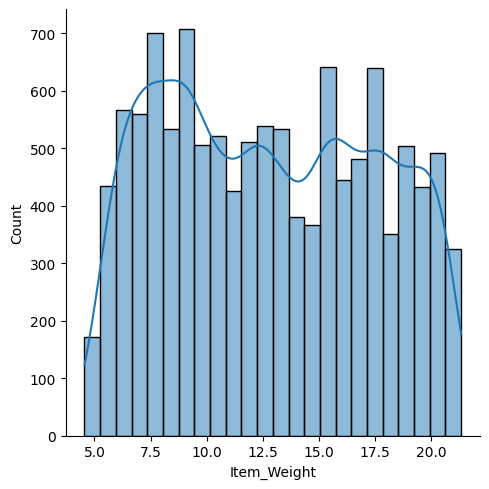

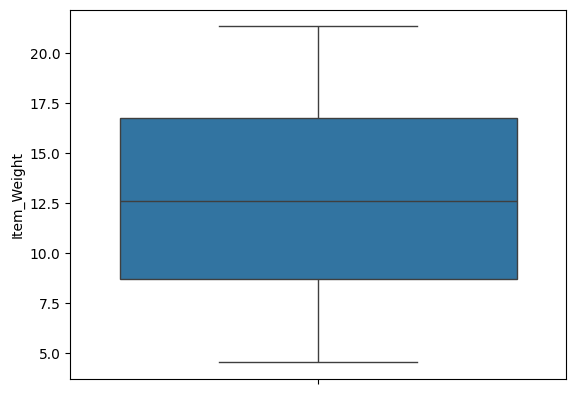

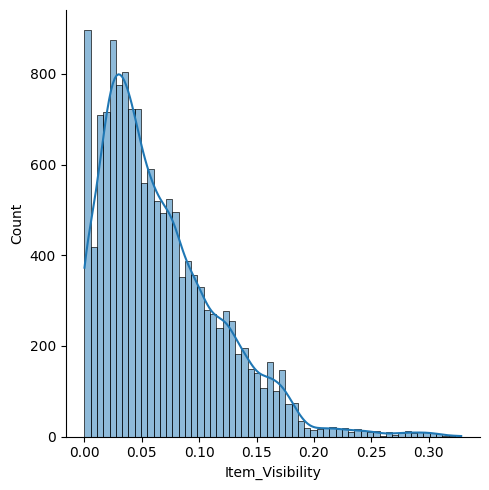

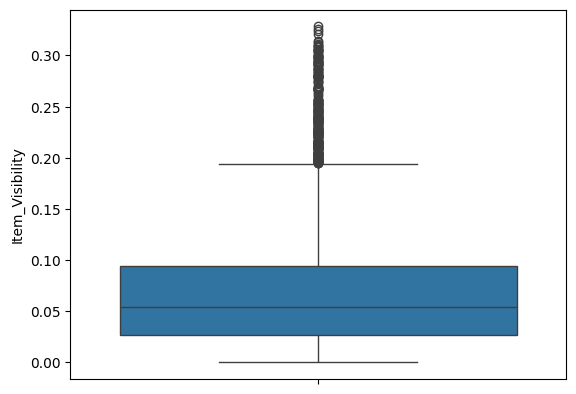

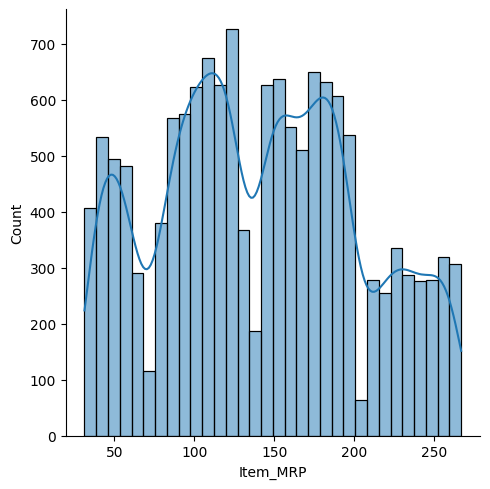

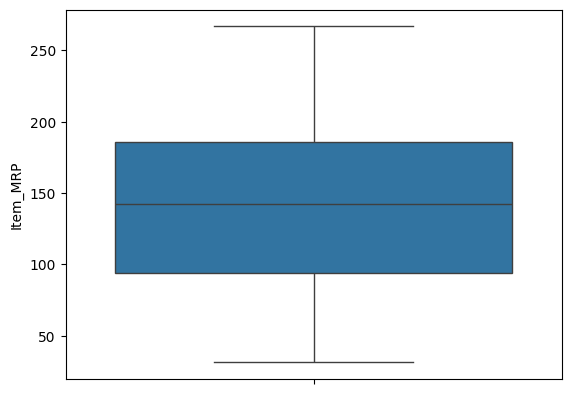

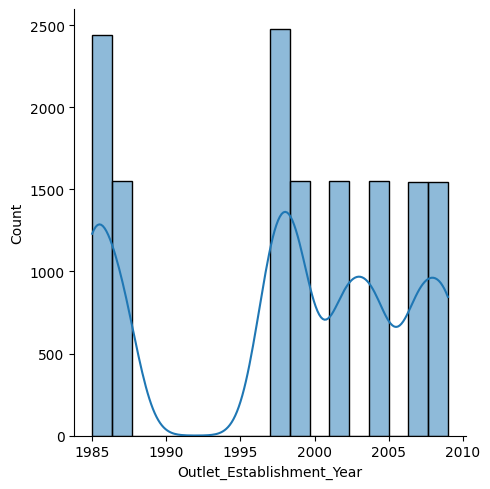

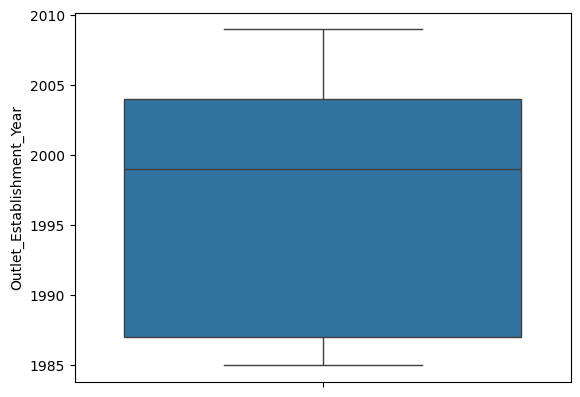

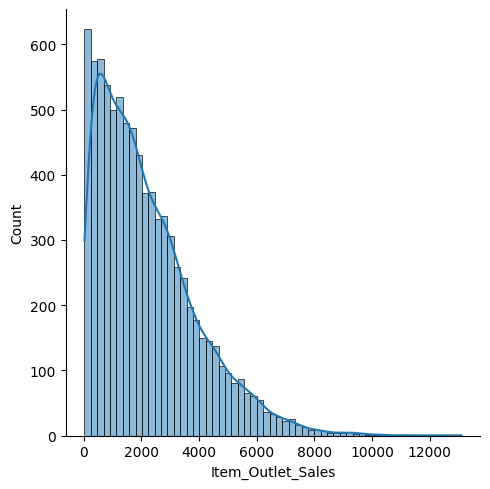

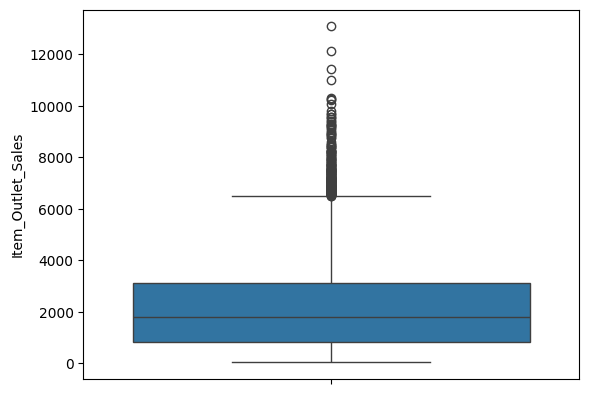

In [12]:
for i in data.select_dtypes(include="number"):
    sns.displot(data[i], kde="True")
    plt.show()
    sns.boxplot(data[i])
    plt.show()

<Axes: xlabel='count', ylabel='Item_Type'>

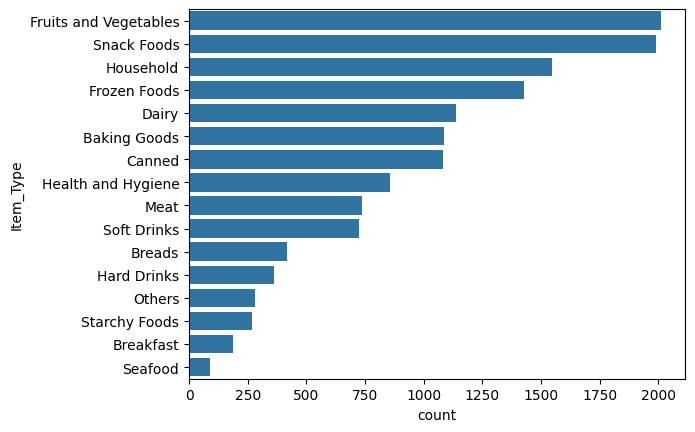

In [13]:
sns.countplot(data=data, y="Item_Type", order=data["Item_Type"].value_counts().index)

# Data Visualisation

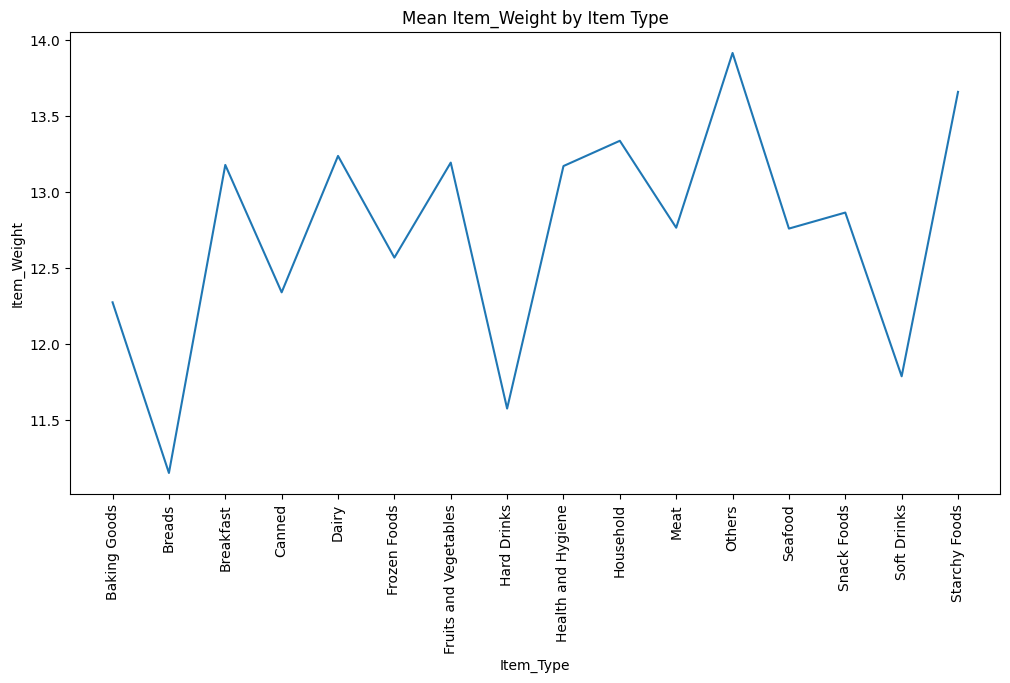

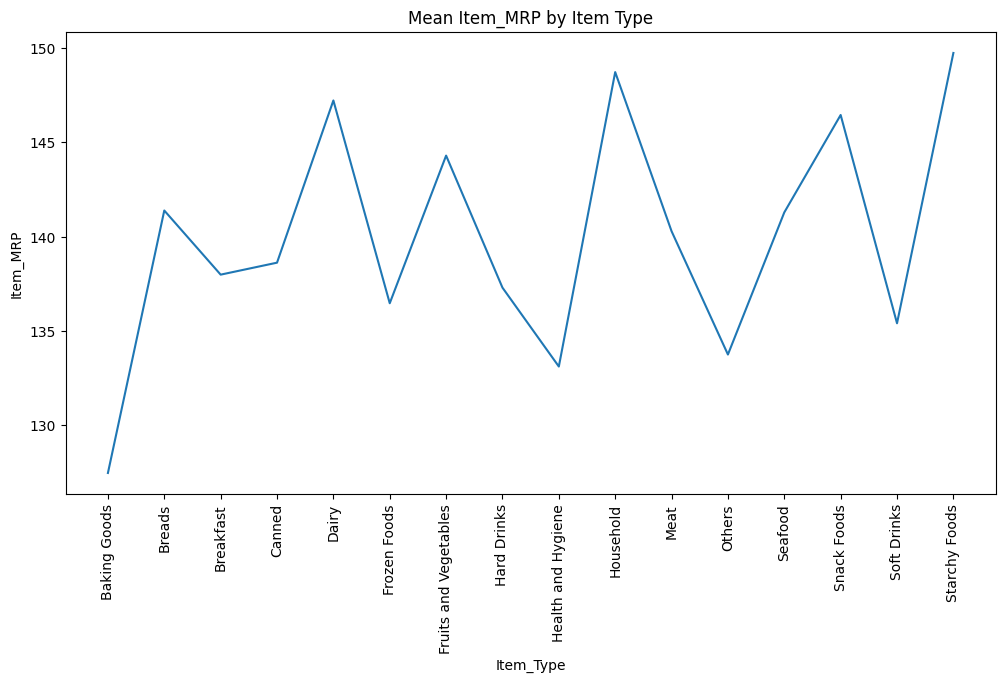

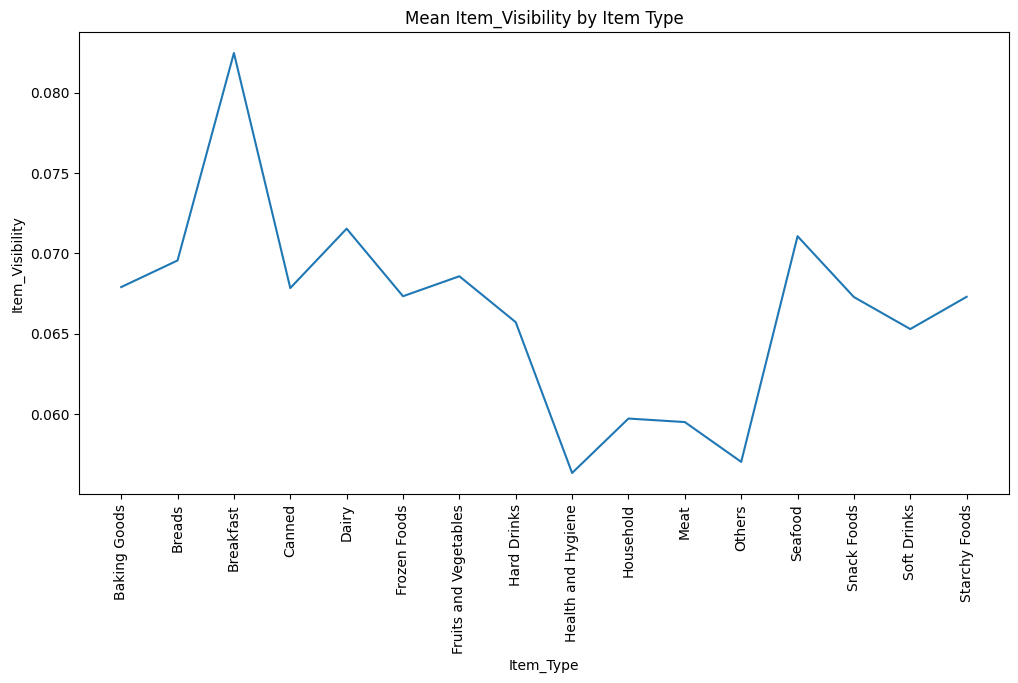

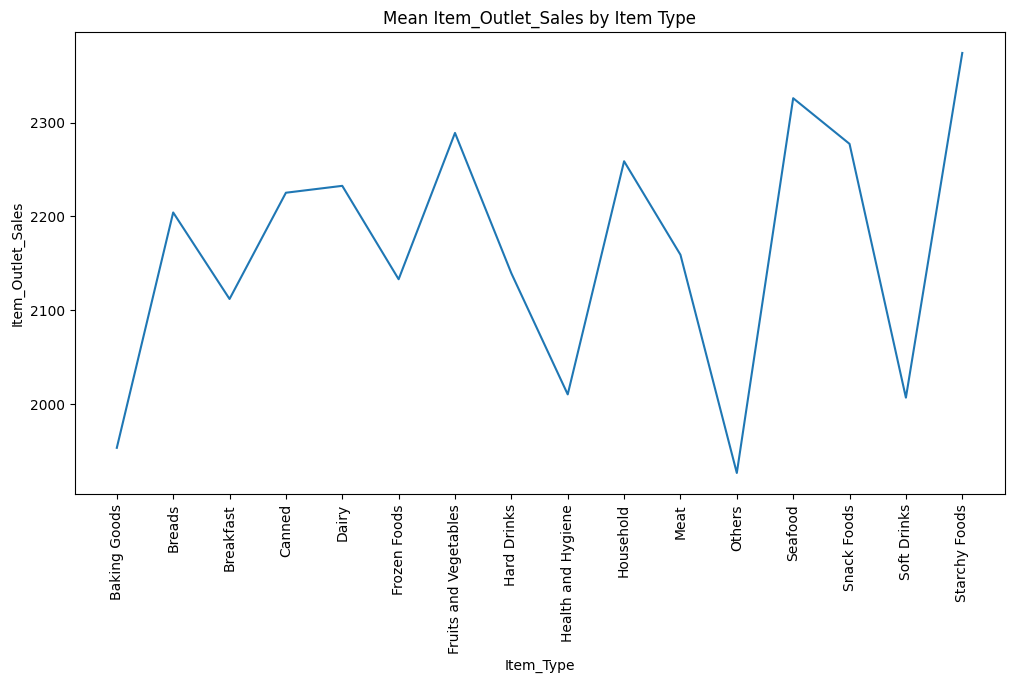

In [14]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).mean())
    plt.xticks(rotation=90)
    plt.title(f'Mean {i} by Item Type')
    plt.show()


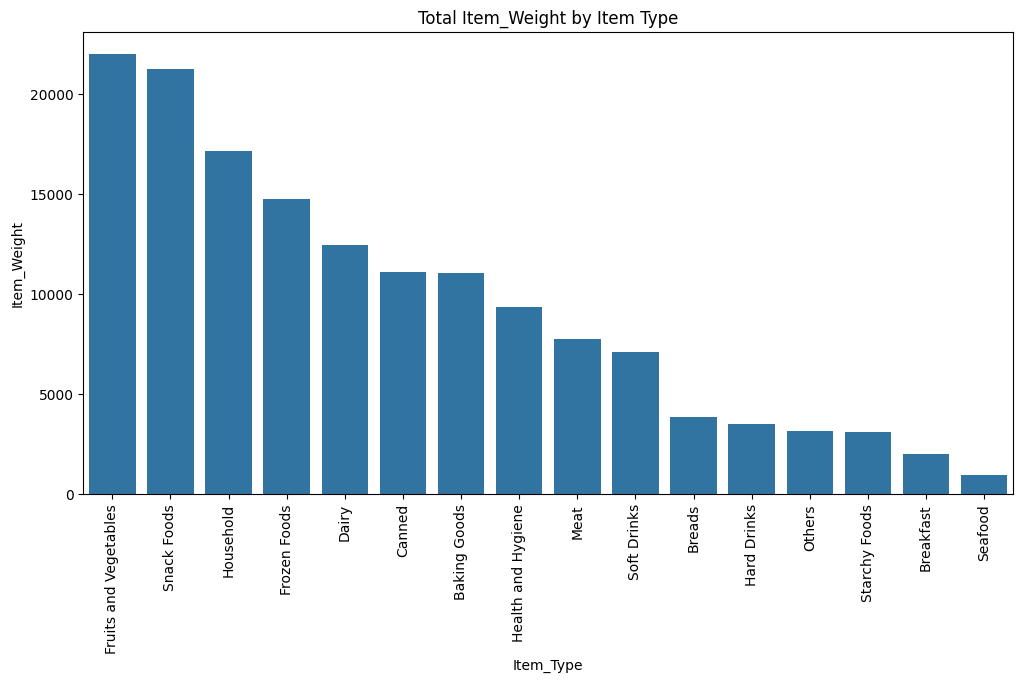

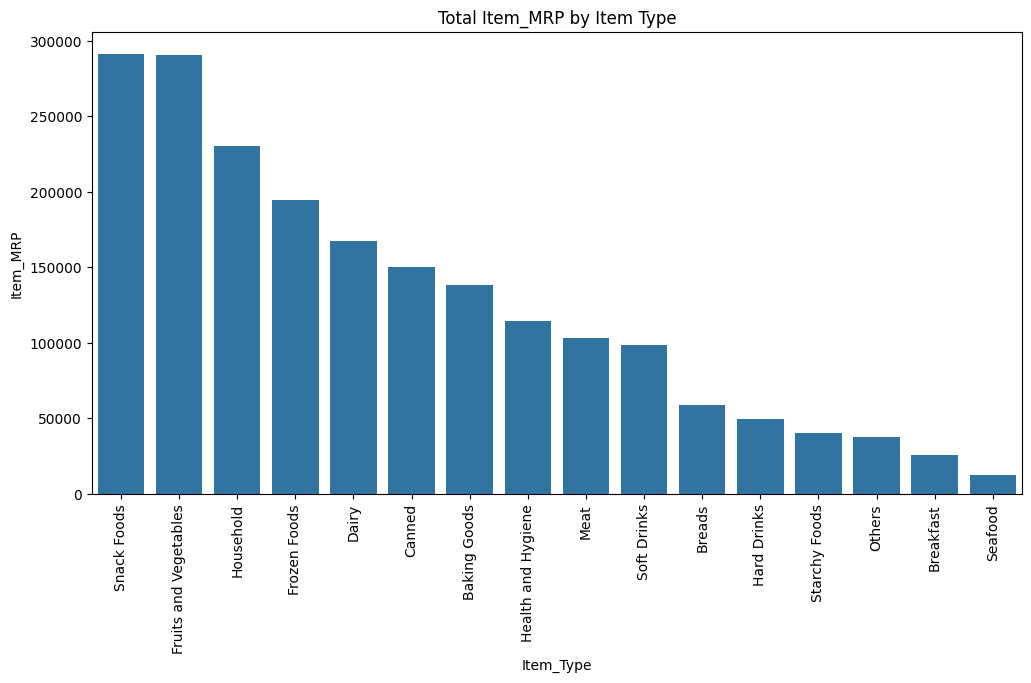

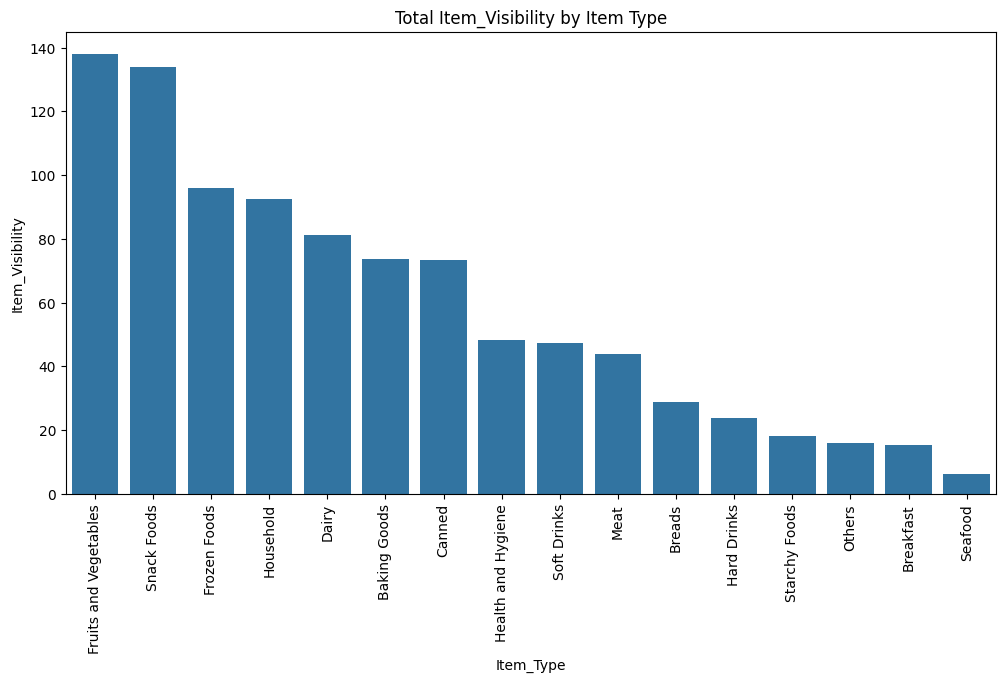

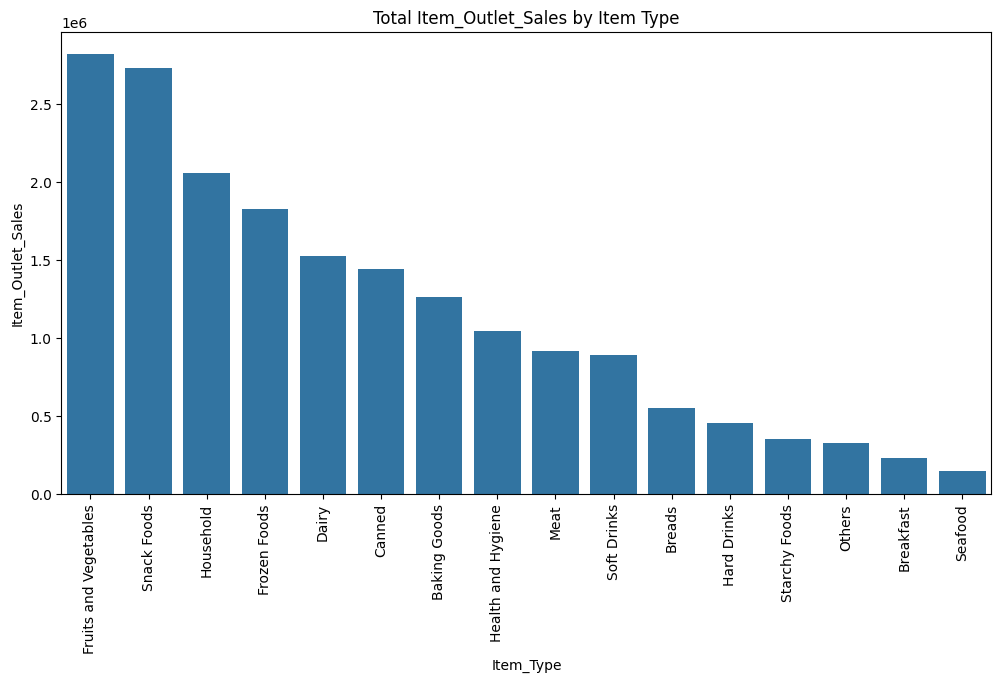

In [15]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).sum().sort_values([i],ascending=False
                                                                                                        ))
    plt.xticks(rotation=90)
    plt.title(f'Total {i} by Item Type')
    plt.show()


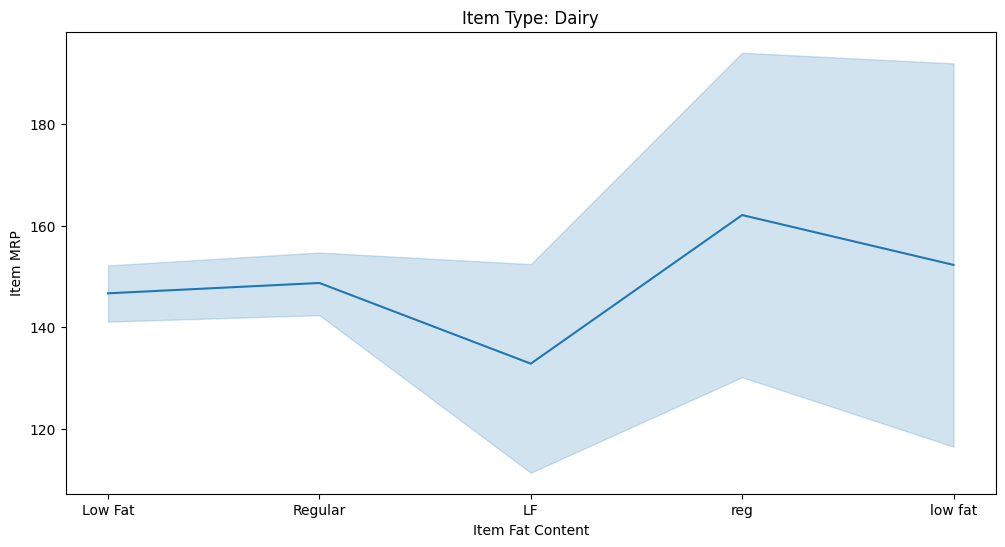

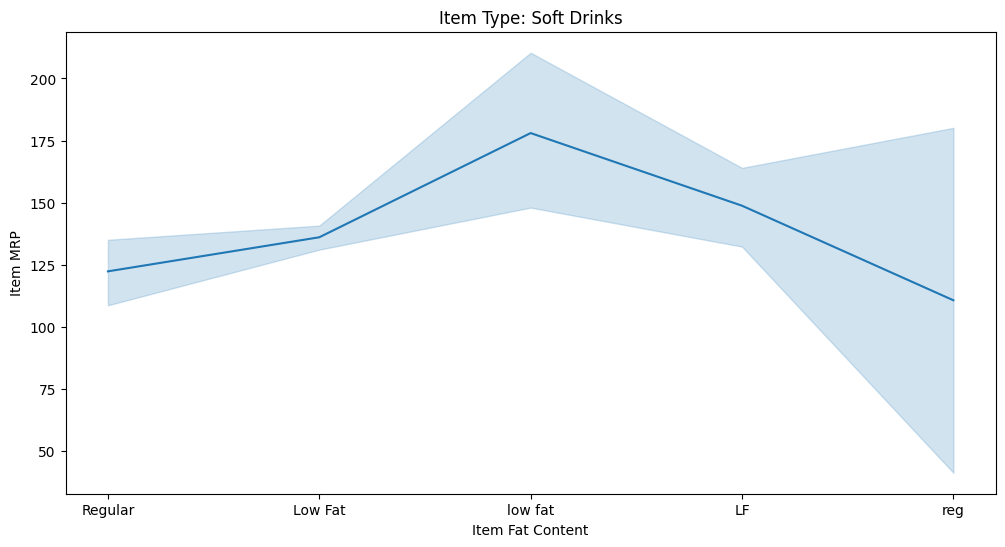

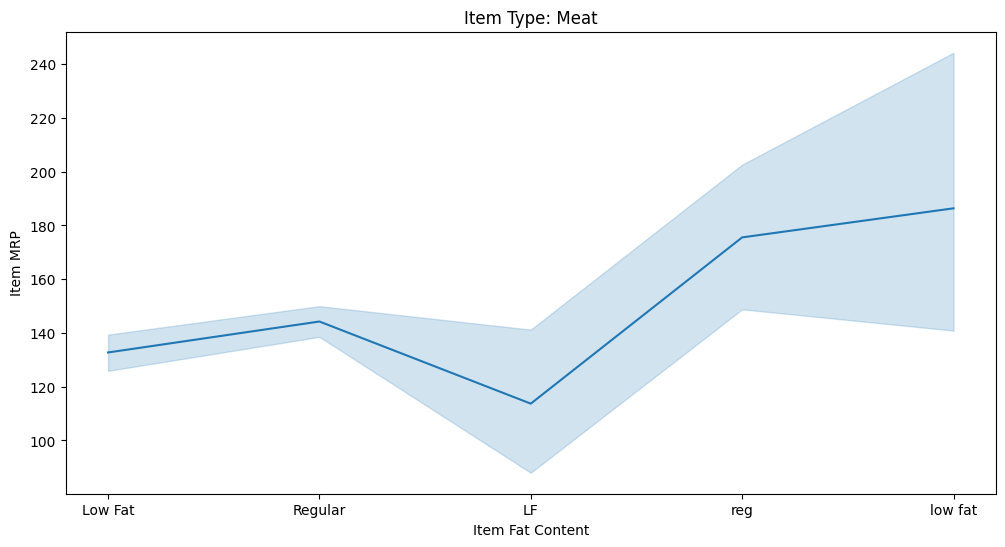

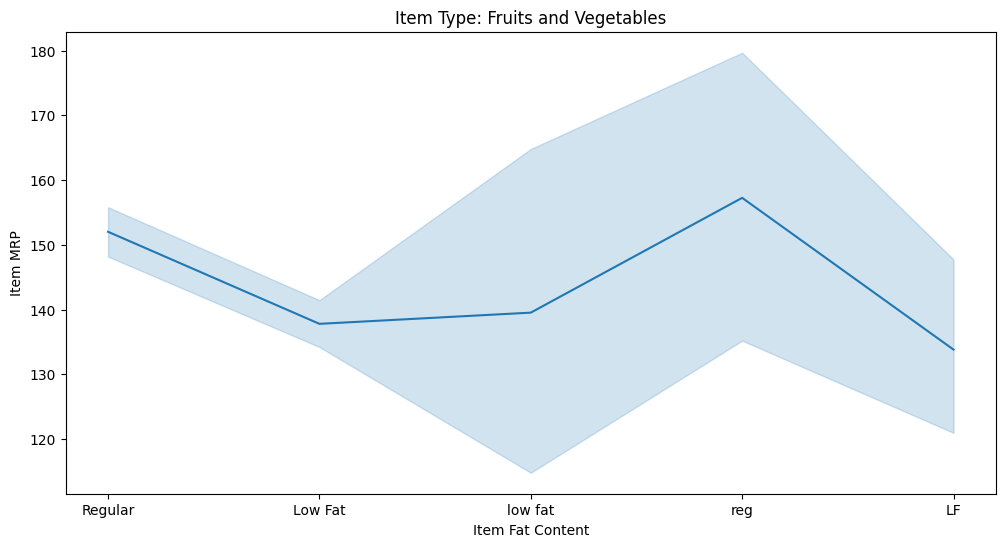

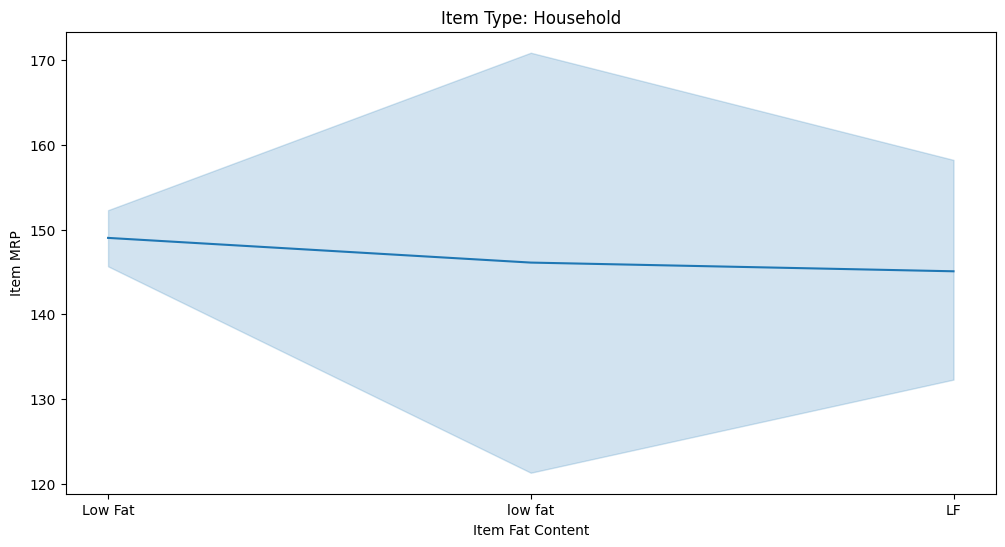

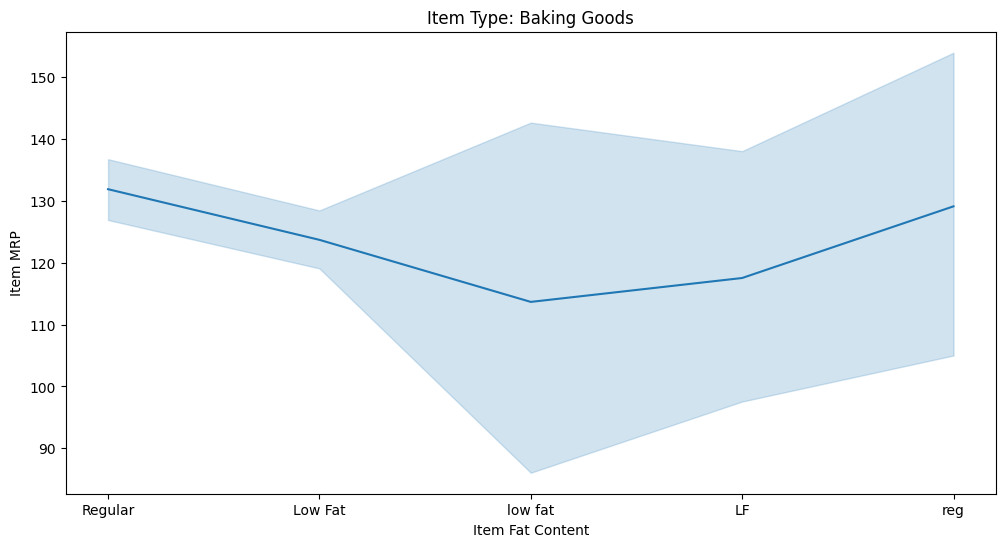

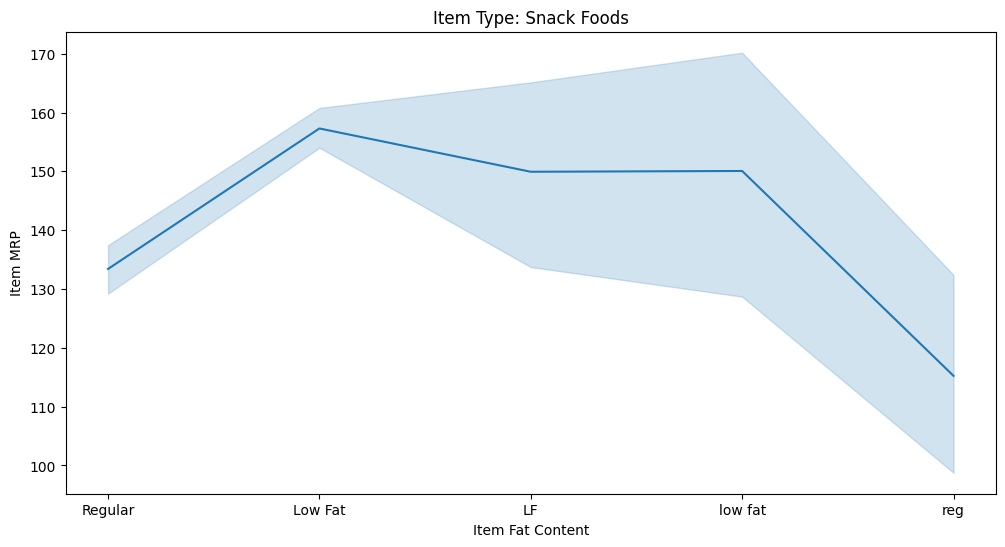

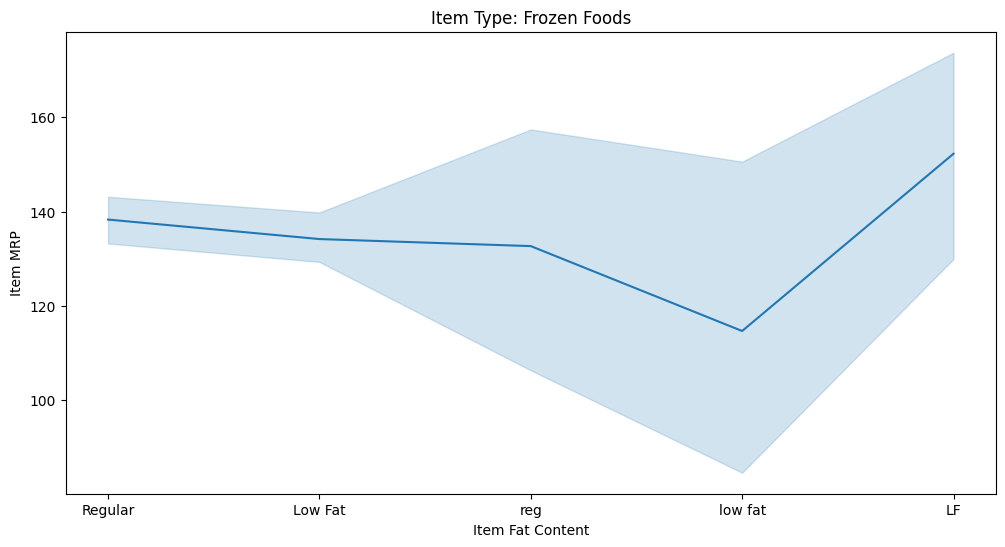

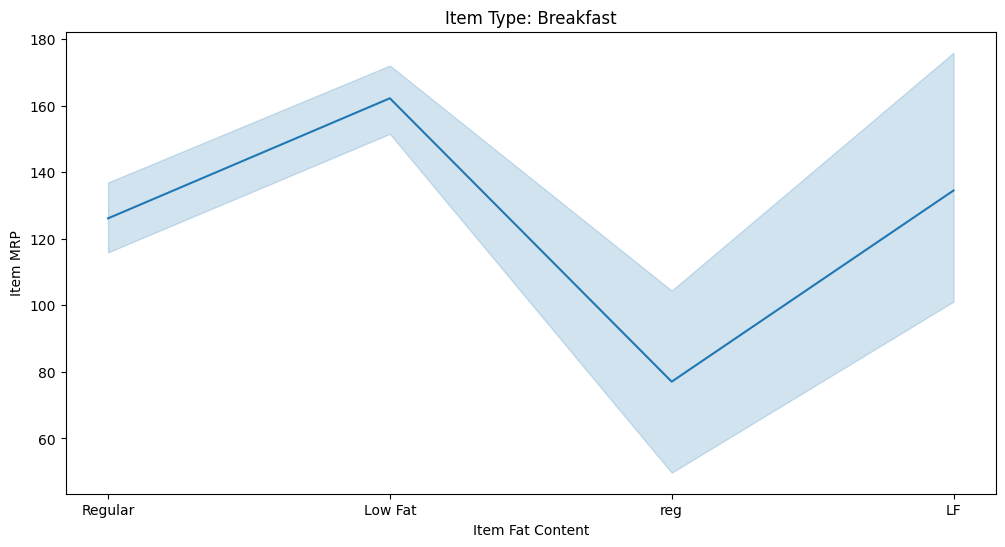

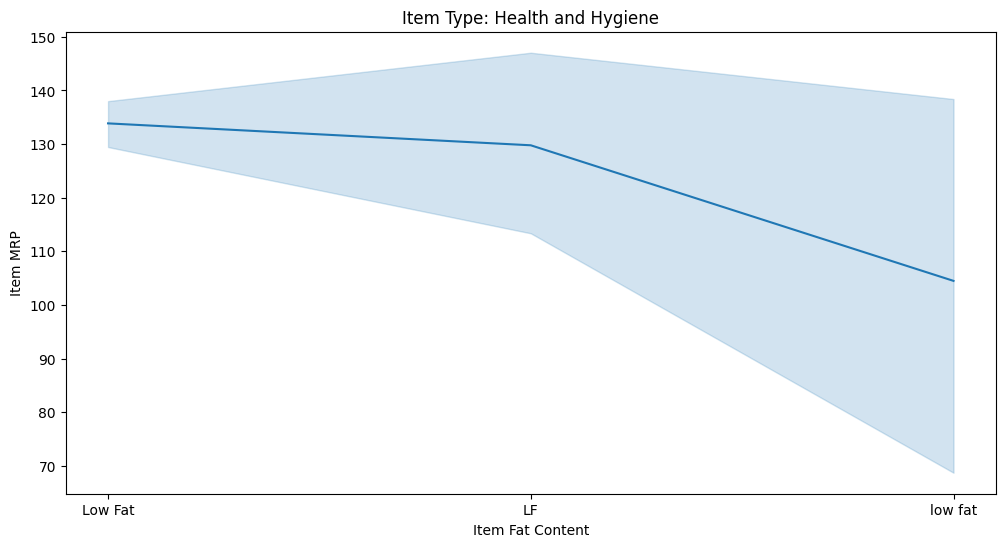

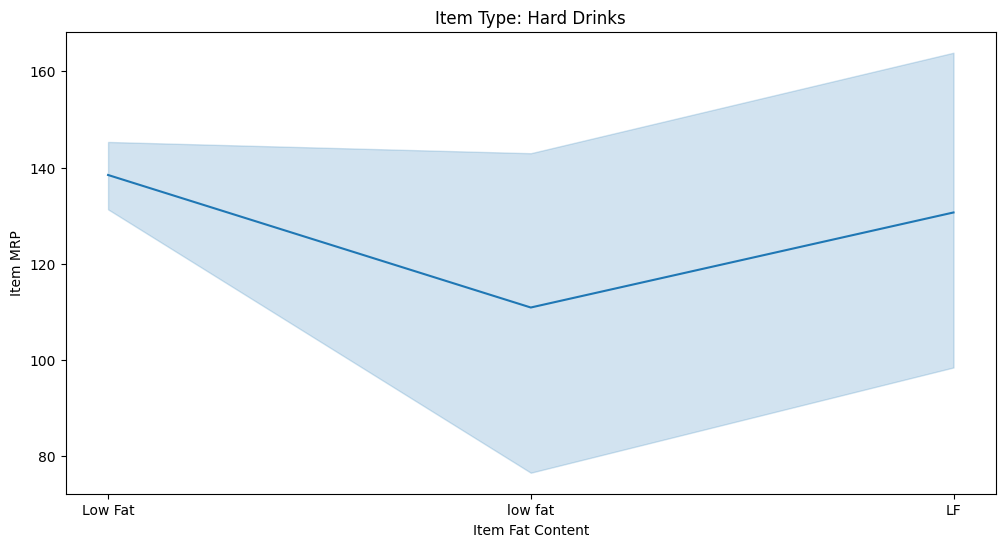

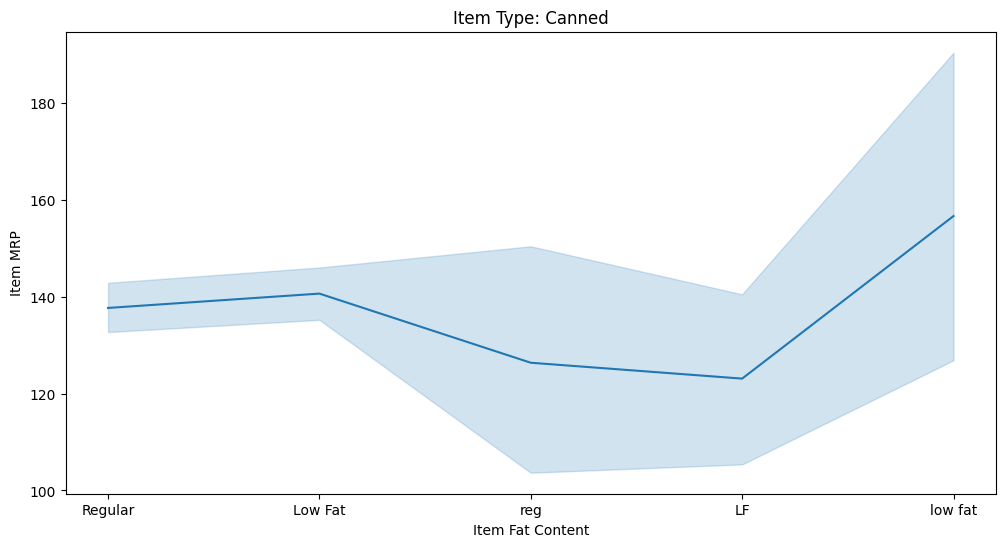

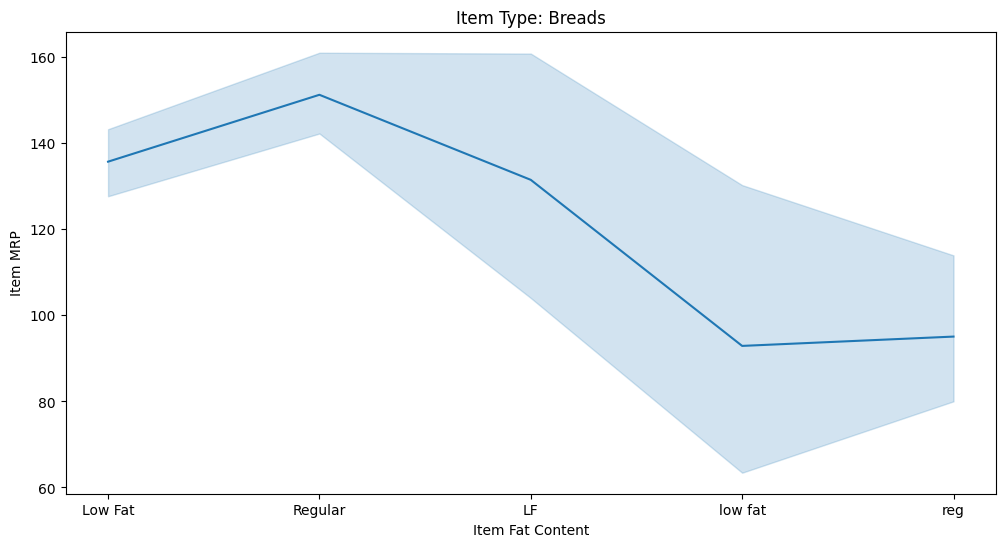

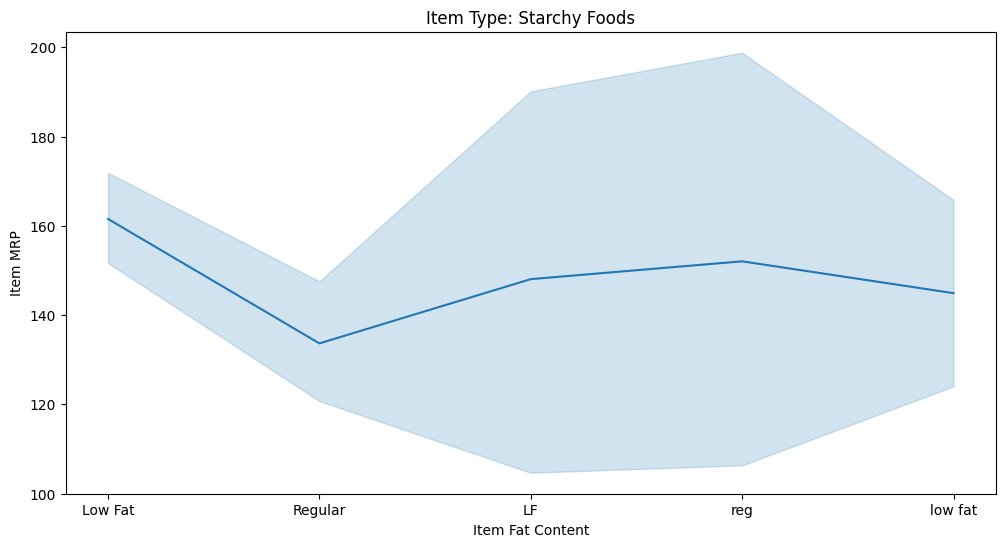

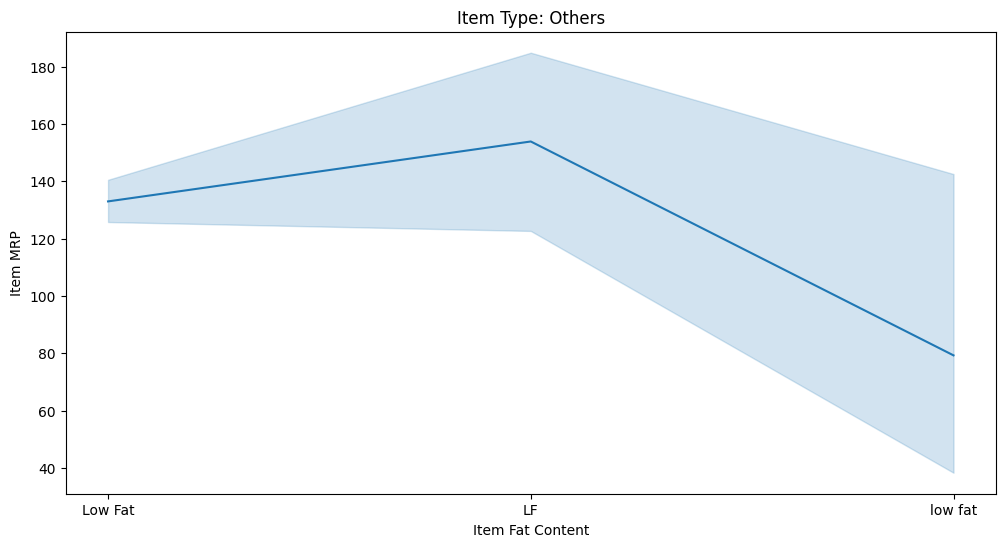

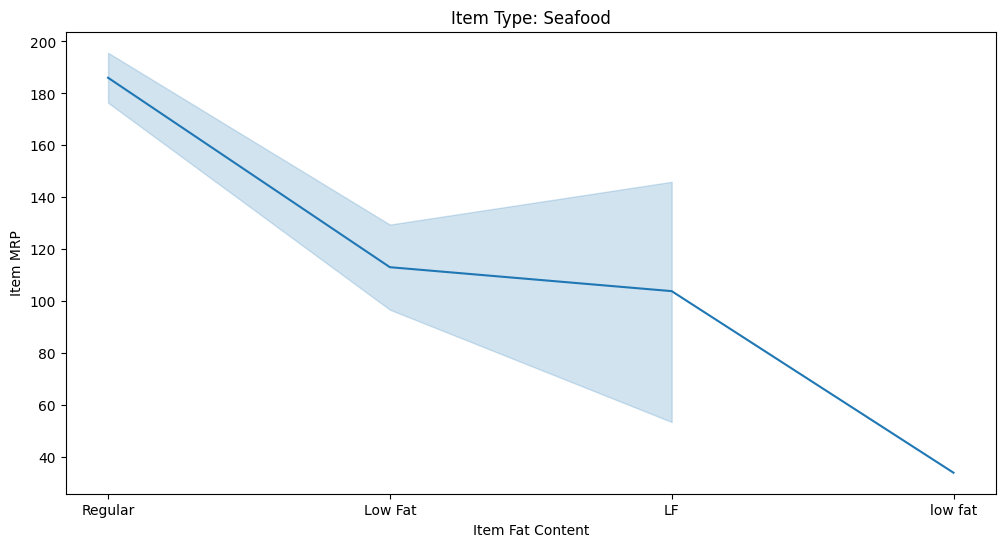

In [16]:
item_types = data["Item_Type"].unique()

for i, item_type in enumerate(item_types):
    plt.figure(figsize=(12, 6))
    sns.lineplot(y="Item_MRP", x="Item_Fat_Content", data=data[data["Item_Type"] == item_type])
    plt.xlabel("Item Fat Content")
    plt.ylabel("Item MRP")
    plt.title(f"Item Type: {item_type}")
    plt.show()

Text(0.5, 0, 'Outlet Type')

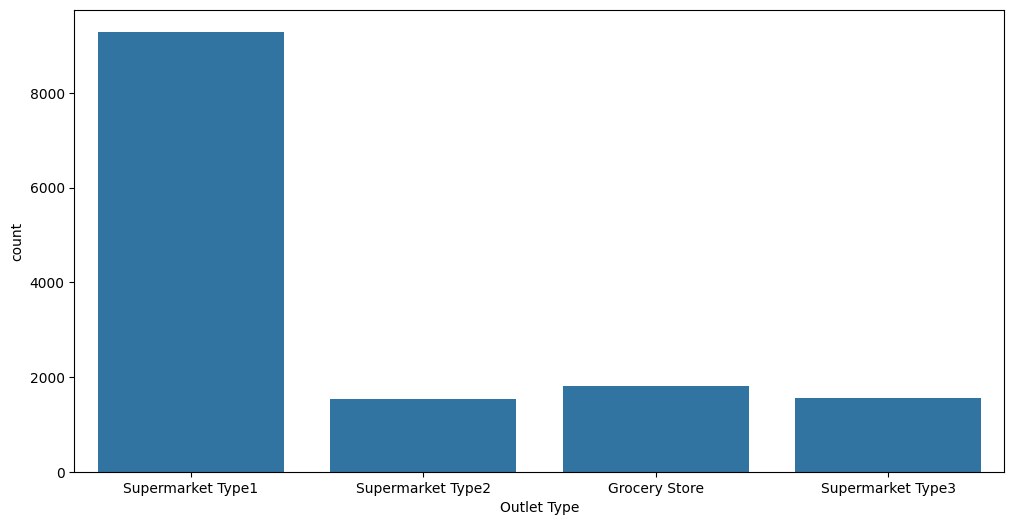

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(data=data,x="Outlet_Type")
plt.xlabel("Count of Outlet Type")
plt.xlabel("Outlet Type")

Text(0.5, 0, 'Outlet Location Type')

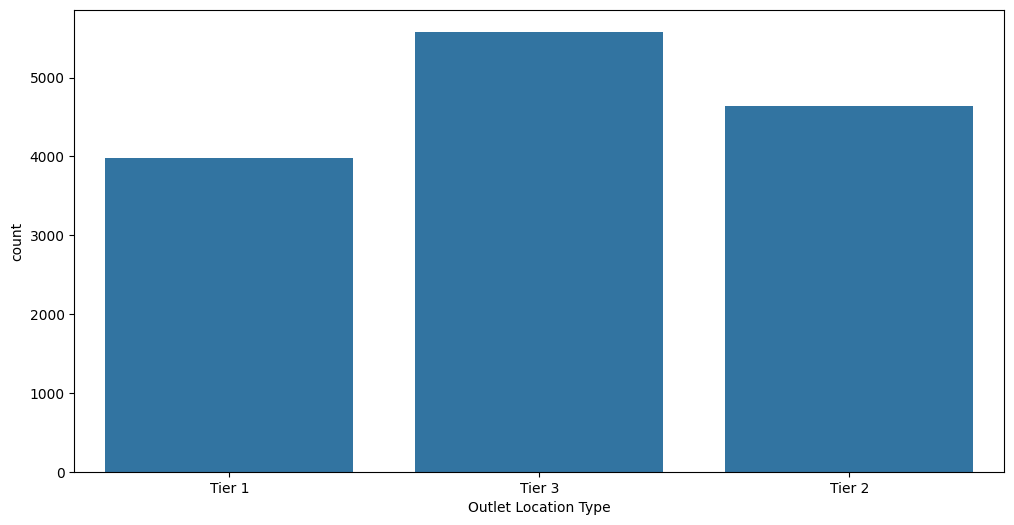

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(data=data,x="Outlet_Location_Type")
plt.xlabel("Count of Outlet Location Type")
plt.xlabel("Outlet Location Type")

<Axes: xlabel='Outlet_Identifier', ylabel='Outlet_Establishment_Year'>

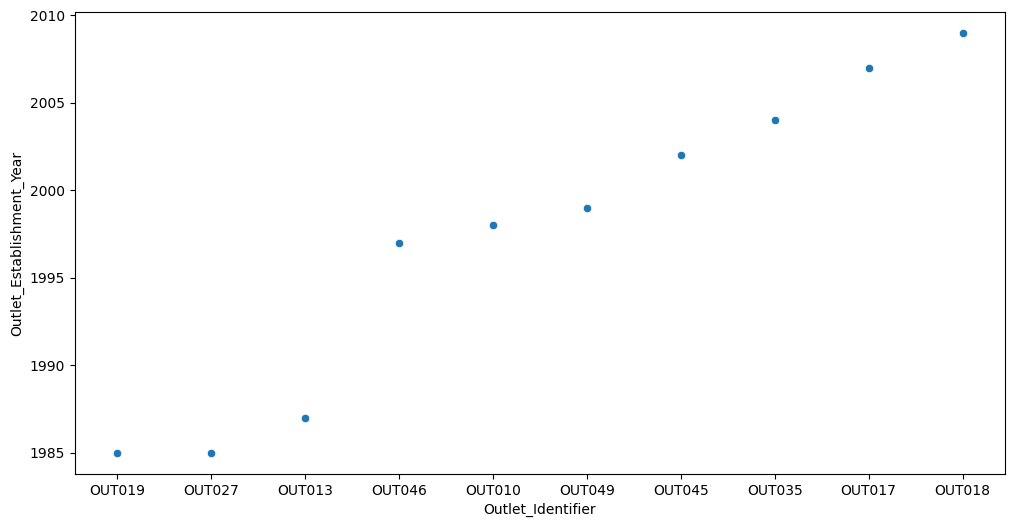

In [19]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=data.groupby(["Outlet_Establishment_Year","Outlet_Identifier"]).sum(),x="Outlet_Identifier",y="Outlet_Establishment_Year")

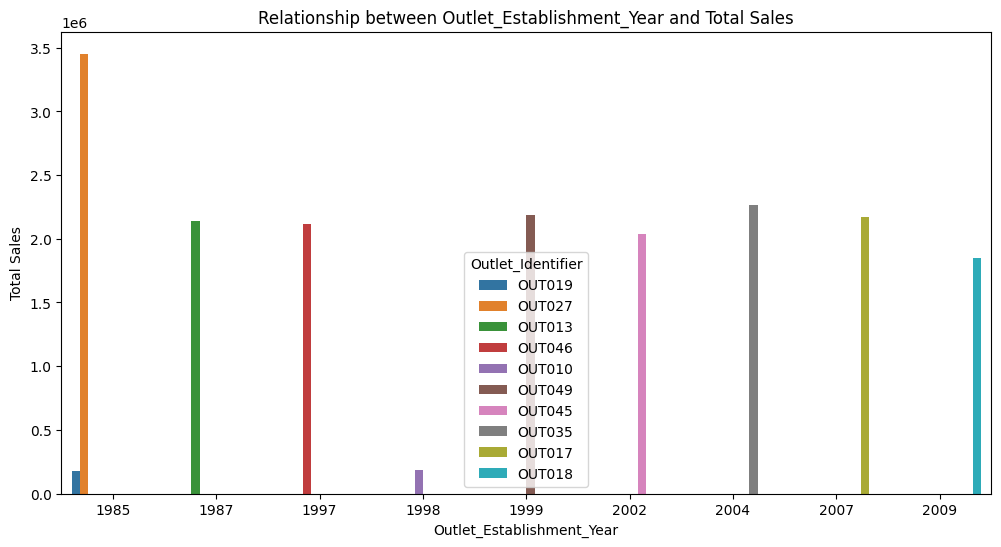

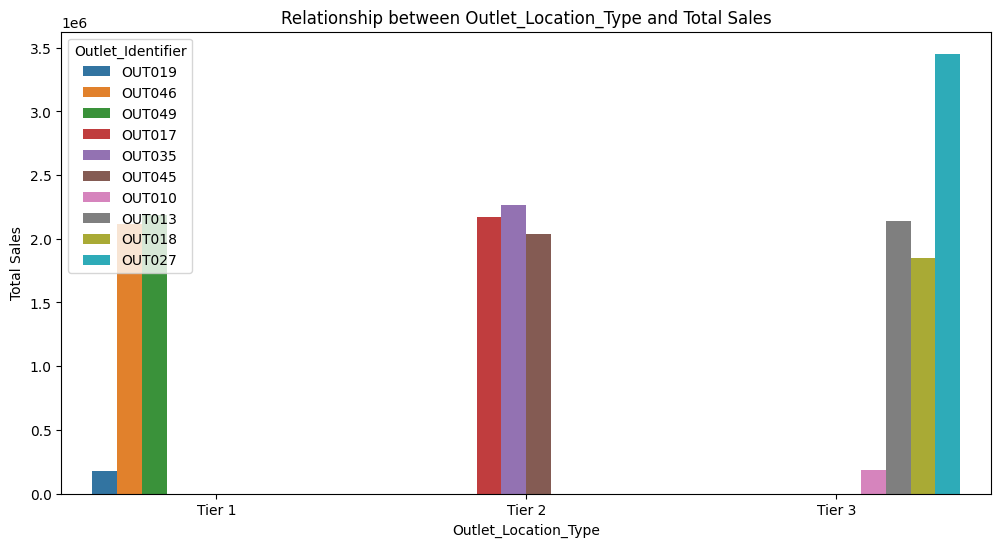

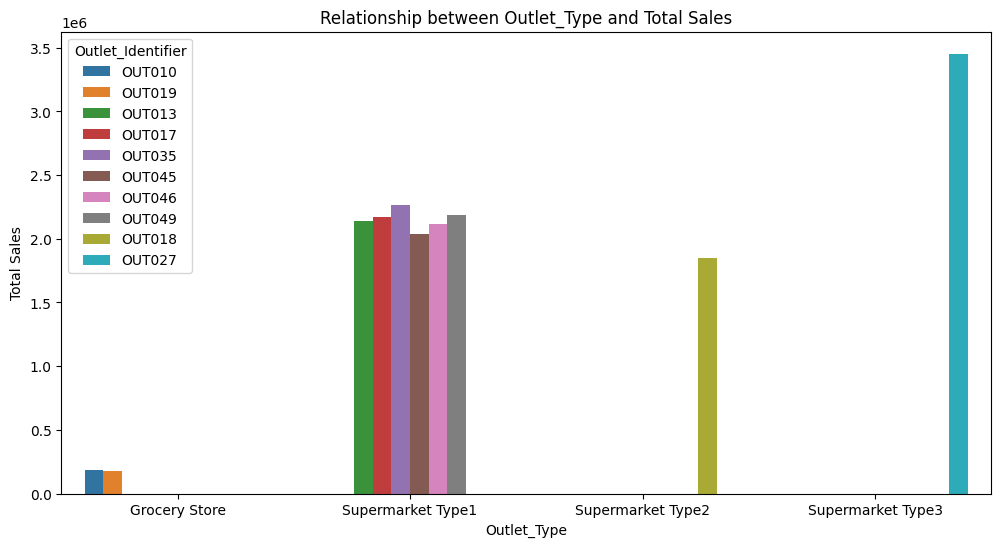

In [20]:
for i in ["Outlet_Establishment_Year", "Outlet_Location_Type", "Outlet_Type"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data.groupby([i, "Outlet_Identifier"]).sum(),
        hue="Outlet_Identifier",
        x=i,
        y="Item_Outlet_Sales",
    )
    plt.xlabel(i)
    plt.ylabel("Total Sales")
    plt.title(f"Relationship between {i} and Total Sales")
    plt.show()

In [21]:
data["Outlet_Identifier"].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

# Data preprocessing

We will begin with checking the Item_Fat_Content because that seems to be having sound suspicious unique values. There are different spellings to the same thing, which can be corrected to generalise the fat content, for example:-

- lf, low fat , LF can become Low Fat
- reg can become Regular

In [22]:
print(data["Item_Fat_Content"].unique())
data.replace(
    {"Item_Fat_Content": {"low_fat": "Low Fat", "lf": "Low Fat", "LF": "Low Fat"}},
    inplace=True,
)

data.replace({"Item_Fat_Content": {"reg": "Regular"}}, inplace=True)


print(data["Item_Fat_Content"].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Low Fat' 'Regular' 'low fat']


## Treat Missing Data

### Treat the missing values for Item Weight

Since the item identifiers are duplicated in the dataset, it is possible that the weight has been entered in one observation but missing in another for the same item identifier, therefore, we are first checking what item identifiers have weights in one of the many recorded observations. We are substituting these observations with the present observation.

We also calculate what item identifiers do not have item weight in any of the recorded observations. We fill these item weight gaps using the mean of the weights of their item types. This has been supported by drawing a distribution plot for the weights of the items grouped by item types, to ensure we are not dealing with any outliers or exceptional cases, that may make our assumption erroneous. 

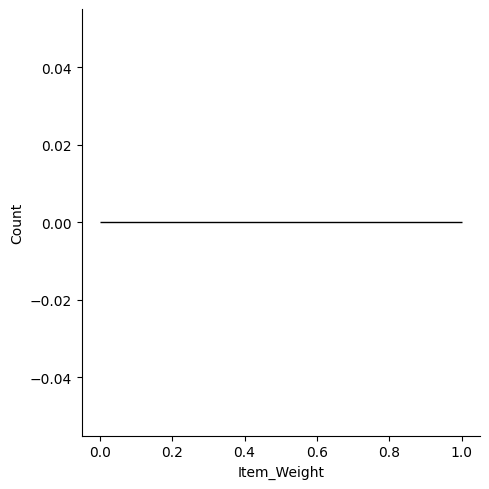

In [23]:
items_without_weight =  set(
    data.loc[data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_item_weight = set(
    data.loc[-data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_missing_weight = items_without_weight.intersection(
    items_with_item_weight
)

items_with_absent_weight = items_without_weight.difference(items_with_item_weight)

weight = data[
    (data["Item_Identifier"].isin(items_with_missing_weight))
    & (-data["Item_Weight"].isna())
].iloc[0]["Item_Weight"]

data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
] = data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
].fillna(
    weight
)


item_types = set()
item_types.update(
    set(
        data.loc[
            data["Item_Identifier"].isin(items_with_absent_weight),
            "Item_Type",
        ].unique()
    )
)
sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)

average_weights = {}


for i in item_types:
    sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)
    plt.title(f"Item Weight Distribution for Item Type {i}")
    average_weights[i] = data[data["Item_Type"] == i]["Item_Weight"].mean()

for i in items_with_absent_weight:
    data.loc[data["Item_Identifier"] == i, "Item_Weight"] = data.loc[
        data["Item_Identifier"] == i, "Item_Weight"
    ].fillna(
        average_weights.get(data.loc[data["Item_Identifier"] == i, "Item_Type"].iloc[0])
    )

### Treat the missing values for Outlet Size

Number of outlets that have sizes but missing in one of the rows of items: 0
Number of outlets that do not have sizes in any of the rows: 3
Outlets identifiers without any size: {'OUT017', 'OUT010', 'OUT045'}
             Outlet_Type Outlet_Location_Type Outlet_Size
3          Grocery Store               Tier 3         NaN
8      Supermarket Type1               Tier 2         NaN
9      Supermarket Type1               Tier 2         NaN
25     Supermarket Type1               Tier 2         NaN
28         Grocery Store               Tier 3         NaN
...                  ...                  ...         ...
14191      Grocery Store               Tier 3         NaN
14193  Supermarket Type1               Tier 2         NaN
14201  Supermarket Type1               Tier 2         NaN
14202  Supermarket Type1               Tier 2         NaN
14203  Supermarket Type1               Tier 2         NaN

[4016 rows x 3 columns]
['Tier 3' 'Tier 2']
['Grocery Store' 'Supermarket Type1']


Text(0, 0.5, 'Unique Outlet Size Count')

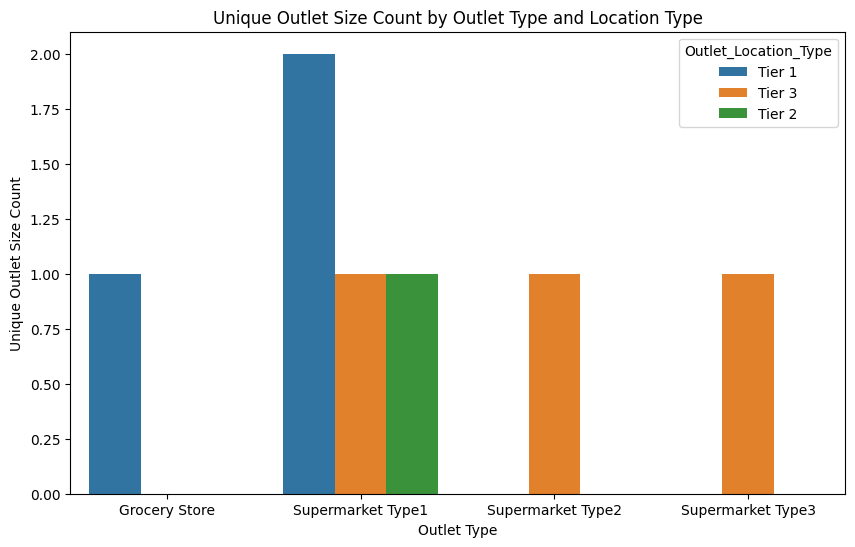

In [24]:
outlets_without_size = set(
    data.loc[data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_size = set(
    data.loc[-data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_missing_size = outlets_without_size.intersection(outlets_with_size)

outlets_with_absent_size = outlets_without_size.difference(outlets_with_size)

print(
    f"Number of outlets that have sizes but missing in one of the rows of items: {len(outlets_with_missing_size)}"
)

print(
    f"Number of outlets that do not have sizes in any of the rows: {len(outlets_with_absent_size)}"
)

print(f"Outlets identifiers without any size: {outlets_with_absent_size}")


print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        ["Outlet_Type", "Outlet_Location_Type", "Outlet_Size"],
    ]
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Location_Type",
    ].unique()
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Type",
    ].unique()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Outlet_Type",
    y="Unique_Size_Count",
    hue="Outlet_Location_Type",
    data=data.groupby(["Outlet_Type", "Outlet_Location_Type"])["Outlet_Size"]
    .nunique()
    .reset_index(name="Unique_Size_Count"),
)
plt.title("Unique Outlet Size Count by Outlet Type and Location Type")
plt.xlabel("Outlet Type")
plt.ylabel("Unique Outlet Size Count")


In [25]:
data.loc[
    data["Outlet_Location_Type"].isin(["Tier 3"]),
    ["Outlet_Identifier", "Outlet_Size"],
]["Outlet_Size"].unique()

data.loc[
    data["Outlet_Type"].isin(["Grocery Store"]),
    ["Outlet_Identifier", "Outlet_Size"],
]["Outlet_Size"].unique()

array([nan, 'Small'], dtype=object)

## Encoding Categorical Data

#### Label Encoding Outlet_Location_Type, Label Encoding Outlet_Size

In [26]:
for i in ["Outlet_Location_Type", "Outlet_Size", "Item_Fat_Content"]:
    data[i] = LabelEncoder().fit_transform(data[i].ravel())

/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_64765/3818429203.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data[i] = LabelEncoder().fit_transform(data[i].ravel())
/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_64765/3818429203.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data[i] = LabelEncoder().fit_transform(data[i].ravel())
/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_64765/3818429203.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data[i] = LabelEncoder().fit_transform(data[i].ravel())


### One-Hot Encoding Item_Fat_Content, Item_Type, "Outlet_Type"

In [27]:
data = pd.get_dummies(data, columns=["Item_Type", "Outlet_Type"])

#### Standardise or Normalise the Outlet_Establishment_Year

In [28]:
data["Outlet_Establishment_Year"] = MinMaxScaler().fit_transform(
    data["Outlet_Establishment_Year"].values.reshape(-1, 1)
)
data["Outlet_Establishment_Year_Normalised"] = normalize(
    data["Outlet_Establishment_Year"].values.reshape(-1, 1), axis=0
)

In [29]:
data.replace({True: 1, False: 0}, inplace=True)
data.head()

/var/folders/pc/8h2z2v0d10j98frv7fjdy6nr0000gn/T/ipykernel_64765/4168460918.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({True: 1, False: 0}, inplace=True)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,...,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_Normalised
0,FDA15,9.30,0,0.016047,249.8092,OUT049,0.583333,1,0,3735.1380,...,0,0,0,0,0,0,1,0,0,0.007668
1,DRC01,5.92,1,0.019278,48.2692,OUT018,1.000000,1,2,443.4228,...,0,0,0,1,0,0,0,1,0,0.013144
2,FDN15,17.50,0,0.016760,141.6180,OUT049,0.583333,1,0,2097.2700,...,0,0,0,0,0,0,1,0,0,0.007668
3,FDX07,19.20,1,0.000000,182.0950,OUT010,0.541667,3,2,732.3800,...,0,0,0,0,0,1,0,0,0,0.007120
4,NCD19,8.93,0,0.000000,53.8614,OUT013,0.083333,0,2,994.7052,...,0,0,0,0,0,0,1,0,0,0.001095


In [30]:
data = data.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Item_Type_Others'])

In [31]:
#seperating test data from combined dataset (rows with NaN values in 'Item_Outlet_Sales')
test_df = data[data['Item_Outlet_Sales'].isna()]

#separating training data from combined dataset (without NaN values in 'Item_Outlet_Sales')
train_df = data.dropna(subset=['Item_Outlet_Sales'])

## Splitting the Data into Train and Test Data

In [32]:
#splitting  training data
X = train_df.drop('Item_Outlet_Sales', axis=1)
y = train_df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Machine Learning

## Model 1: Random Forest 

### Training a Random Forest Regressor

In [33]:
#creating the ML model (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#training the model
rf_model.fit(X_train, y_train)

#prediction on training set
y_pred_train_rf = rf_model.predict(X_train)

### Evaluating a Random Forest Regressor

Random Forest Model Evaluation on Training Set:
R-squared (R2 Score): 0.9370537162342516
Mean Squared Log Error: 0.06844818153425572


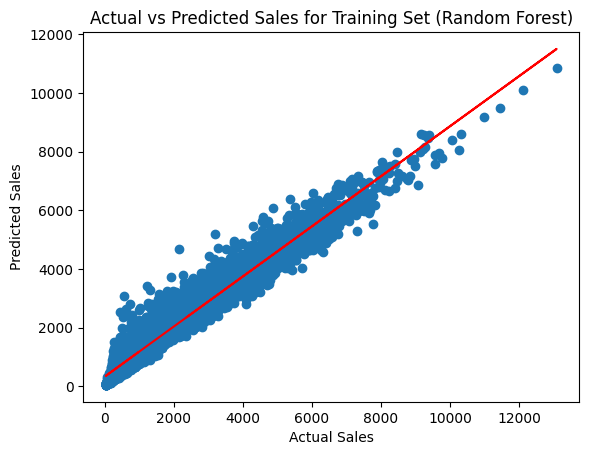

In [34]:
#model evaluation on training set
r2_train_rf = r2_score(y_train, y_pred_train_rf)
msle_train = mean_squared_log_error(y_train, y_pred_train_rf)

print("Random Forest Model Evaluation on Training Set:")
print("R-squared (R2 Score):", r2_train_rf)
print("Mean Squared Log Error:", msle_train)

#visualizing predicted vs actual values for training set
plt.scatter(y_train, y_pred_train_rf)

#line of best fit
fit = np.polyfit(y_train, y_pred_train_rf, deg=1)
plt.plot(y_train, fit[0] * y_train + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest)")
plt.show()

### Predicting the test dataset


Random Forest Model Evaluation on Test Set:
R-squared (R2 Score): 0.5552776729467996
Mean Squared Log Error: 0.30702321588554027


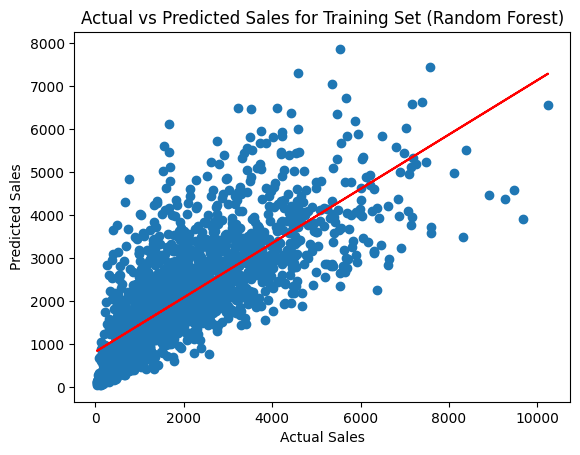

In [35]:
#prediction on test set
y_pred_test_rf = rf_model.predict(X_test)

#model evaluation on test set
r2_test_rf = r2_score(y_test, y_pred_test_rf)
msle_test = mean_squared_log_error(y_test, y_pred_test_rf)

print("\nRandom Forest Model Evaluation on Test Set:")
print("R-squared (R2 Score):", r2_test_rf)
print("Mean Squared Log Error:", msle_test)

#visualizing predicted vs actual values for test set
plt.scatter(y_test, y_pred_test_rf)

#line of best fit
fit = np.polyfit(y_test, y_pred_test_rf, deg=1)
plt.plot(y_test, fit[0] * y_test + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest)")
plt.show()


The model's high R2 score (0.937) and low MSLE (0.068) on the training set indicate strong performance, but the lower R2 score (0.555) and higher MSLE (0.306) on the test set suggest overfitting. To address this, a new DataFrame based on feature importance is created to simplify the model and improve generalization.

### Feature importance for the random forest regressor

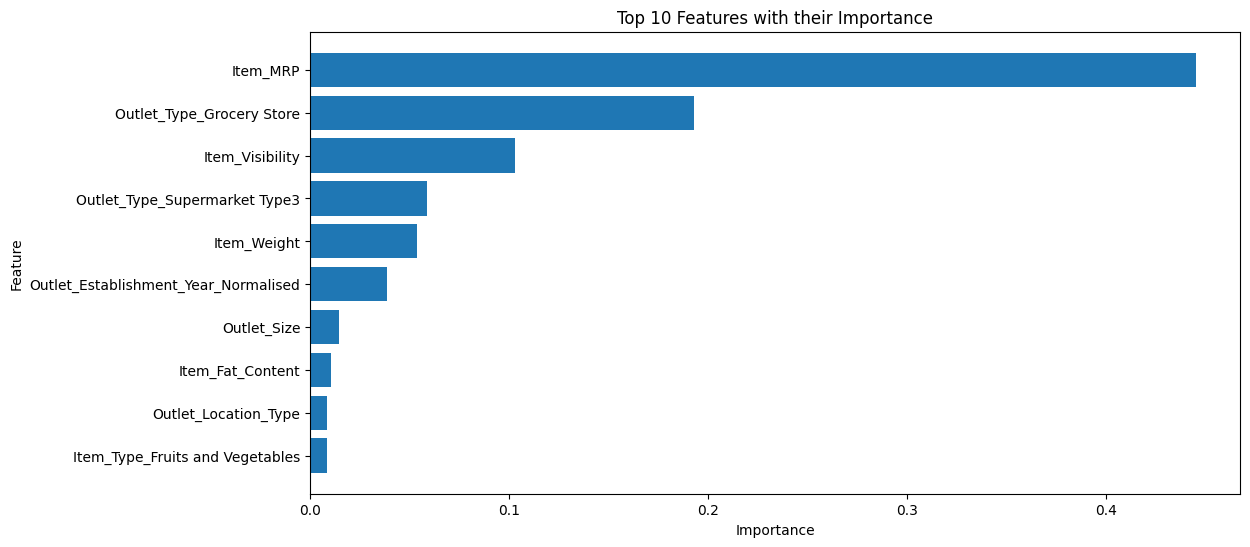

,Feature,Importance
3,Item_MRP,0.445296
21,Outlet_Type_Grocery Store,0.193082
2,Item_Visibility,0.102877
24,Outlet_Type_Supermarket Type3,0.058589
0,Item_Weight,0.053536
25,Outlet_Establishment_Year_Normalised,0.038688
4,Outlet_Size,0.014339
1,Item_Fat_Content,0.010414
5,Outlet_Location_Type,0.008599
12,Item_Type_Fruits and Vegetables,0.008441


In [36]:
#to get feature importances
feature_importances = rf_model.feature_importances_

#creating a df to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

#sorting df by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#plotting the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features with their Importance')
plt.show()

feature_importance_df

### Re-training a new random forest regressor model using the most important features.

In [37]:
#to select features with importance above the threshold (0.02)
selected_features = feature_importance_df.loc[feature_importance_df['Importance'] >= 0.02, 'Feature']

#filtering columns based on selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

#training a new Random Forest model on the selected features
new_rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
new_rf_model.fit(X_train_selected, y_train)

#prediction on the training set
y_pred_train_selected = new_rf_model.predict(X_train_selected)


### Evaluating the newly trained random forest regressor with the most important feature

Random Forest Model Evaluation on Training Set (Selected Features):
R-squared (R2 Score): 0.7065702676147814
Mean Squared Log Error: 0.21731804774023197


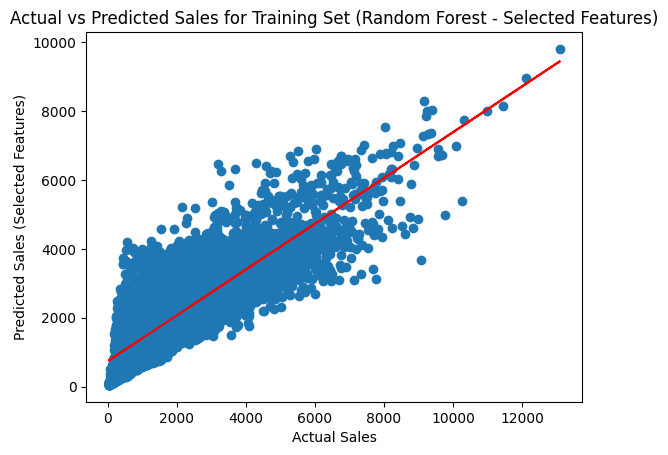

In [38]:
#model evaluation on the training set
r2_train_selected = r2_score(y_train, y_pred_train_selected)
msle_train_sel = mean_squared_log_error(y_train, y_pred_train_selected)

print("Random Forest Model Evaluation on Training Set (Selected Features):")
print("R-squared (R2 Score):", r2_train_selected)
print("Mean Squared Log Error:", msle_train_sel)

#visualizing predicted vs actual values for training set
plt.scatter(y_train, y_pred_train_selected)

#line of best fit
fit = np.polyfit(y_train, y_pred_train_selected, deg=1)
plt.plot(y_train, fit[0] * y_train + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales (Selected Features)")
plt.title("Actual vs Predicted Sales for Training Set (Random Forest - Selected Features)")
plt.show()

### Predicting the test dataset using the newly trained random forest regressor with the most important features


Random Forest Model Evaluation on Test Set (Selected Features):
R-squared (R2 Score): 0.5990875706995739
Mean Squared Log Error: 0.2969417345988403


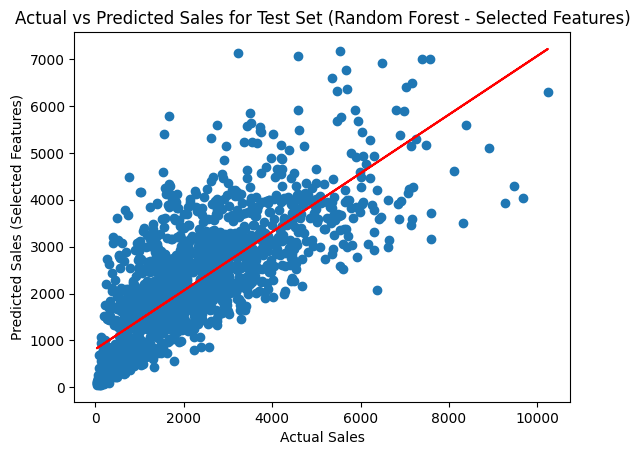

In [39]:
#prediction on test set
y_pred_test_selected = new_rf_model.predict(X_test_selected)

#model evaluation on test set
r2_test_selected = r2_score(y_test, y_pred_test_selected)
msle_test_sel = mean_squared_log_error(y_test, y_pred_test_selected)

print("\nRandom Forest Model Evaluation on Test Set (Selected Features):")
print("R-squared (R2 Score):", r2_test_selected)
print("Mean Squared Log Error:", msle_test_sel)

#visualizing predicted vs actual values for the test set
plt.scatter(y_test, y_pred_test_selected)

#line of best fit
fit = np.polyfit(y_test, y_pred_test_selected, deg=1)
plt.plot(y_test, fit[0] * y_test + fit[1], color='red')

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales (Selected Features)")
plt.title("Actual vs Predicted Sales for Test Set (Random Forest - Selected Features)")
plt.show()

**Conclusion**

The updated model shows a slightly lower R2 score (0.706) and higher MSLE (0.217) on the training data compared to the previous one. However, its R2 score (0.599) and MSLE (0.296) on the test data are closer to the training metrics and higher than the previous model's test metrics. 

This indicates improved generalization and better overall performance, highlighting the effectiveness of the adjustment based on feature importance.

## Model 2: XGBoost Regressor


XGBoost Regressor is like a super-smart tool for predicting numbers in things like prices or scores. It's really good at learning from examples and making accurate guesses, making it handy for tasks where you want to predict numerical values.

XGBoost Regressor is tree-based because it organizes its predictions into a tree-like structure. This helps it break down complex decision-making processes, making it easier to understand and more powerful for tasks like predicting values based on various factors.

XGBoost is one of the ensemble learning methods. XGBoost expects to have the base learners which are uniformly bad at the remainder so that when all the predictions are combined, bad predictions cancels out and better one sums up to form final good predictions.

### Training

In [40]:
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

eval_data = [(dtrain, 'train'), (dtest, 'eval')]


params = {'objective':'reg:squarederror', 'learning_rate':0.1}
model = train(params, dtrain, num_boost_round=100, evals=eval_data)

[0]	train-rmse:1617.76350	eval-rmse:1552.30009
[1]	train-rmse:1529.82893	eval-rmse:1466.61318
[2]	train-rmse:1454.50465	eval-rmse:1393.72019
[3]	train-rmse:1390.35588	eval-rmse:1332.03051
[4]	train-rmse:1335.78320	eval-rmse:1279.72996
[5]	train-rmse:1289.62321	eval-rmse:1234.17188
[6]	train-rmse:1249.89249	eval-rmse:1195.77890
[7]	train-rmse:1216.85672	eval-rmse:1165.15533
[8]	train-rmse:1189.12476	eval-rmse:1141.14191
[9]	train-rmse:1165.90161	eval-rmse:1121.64495
[10]	train-rmse:1146.64482	eval-rmse:1103.71184
[11]	train-rmse:1130.15951	eval-rmse:1089.89626
[12]	train-rmse:1116.47606	eval-rmse:1078.62540
[13]	train-rmse:1104.29712	eval-rmse:1069.31663
[14]	train-rmse:1094.09312	eval-rmse:1061.90760
[15]	train-rmse:1085.95413	eval-rmse:1056.19947
[16]	train-rmse:1078.65046	eval-rmse:1052.08956
[17]	train-rmse:1072.39507	eval-rmse:1048.36402
[18]	train-rmse:1067.24180	eval-rmse:1044.79602
[19]	train-rmse:1062.67836	eval-rmse:1043.19606
[20]	train-rmse:1058.92585	eval-rmse:1041.96437
[2

### Prediction & Evaluation

Mean Absolute Error: 734.9803088173287
Mean Squared Error 1126631.5339931054
Root Mean Squared Error: 1061.4290056301954


/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


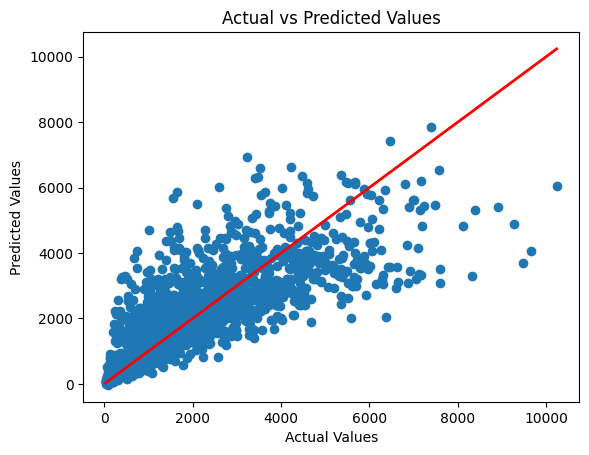

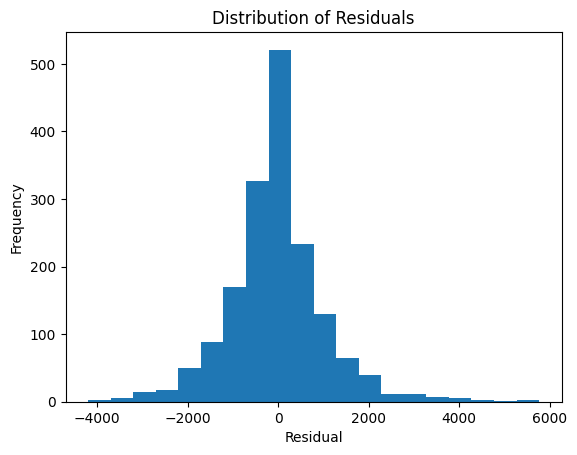

In [41]:
predictions = model.predict(dtest)


# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error {mse}')

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Root Mean Squared Error: {rmse}")



plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


plt.hist(y_test - predictions, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

### Corelation Matrix

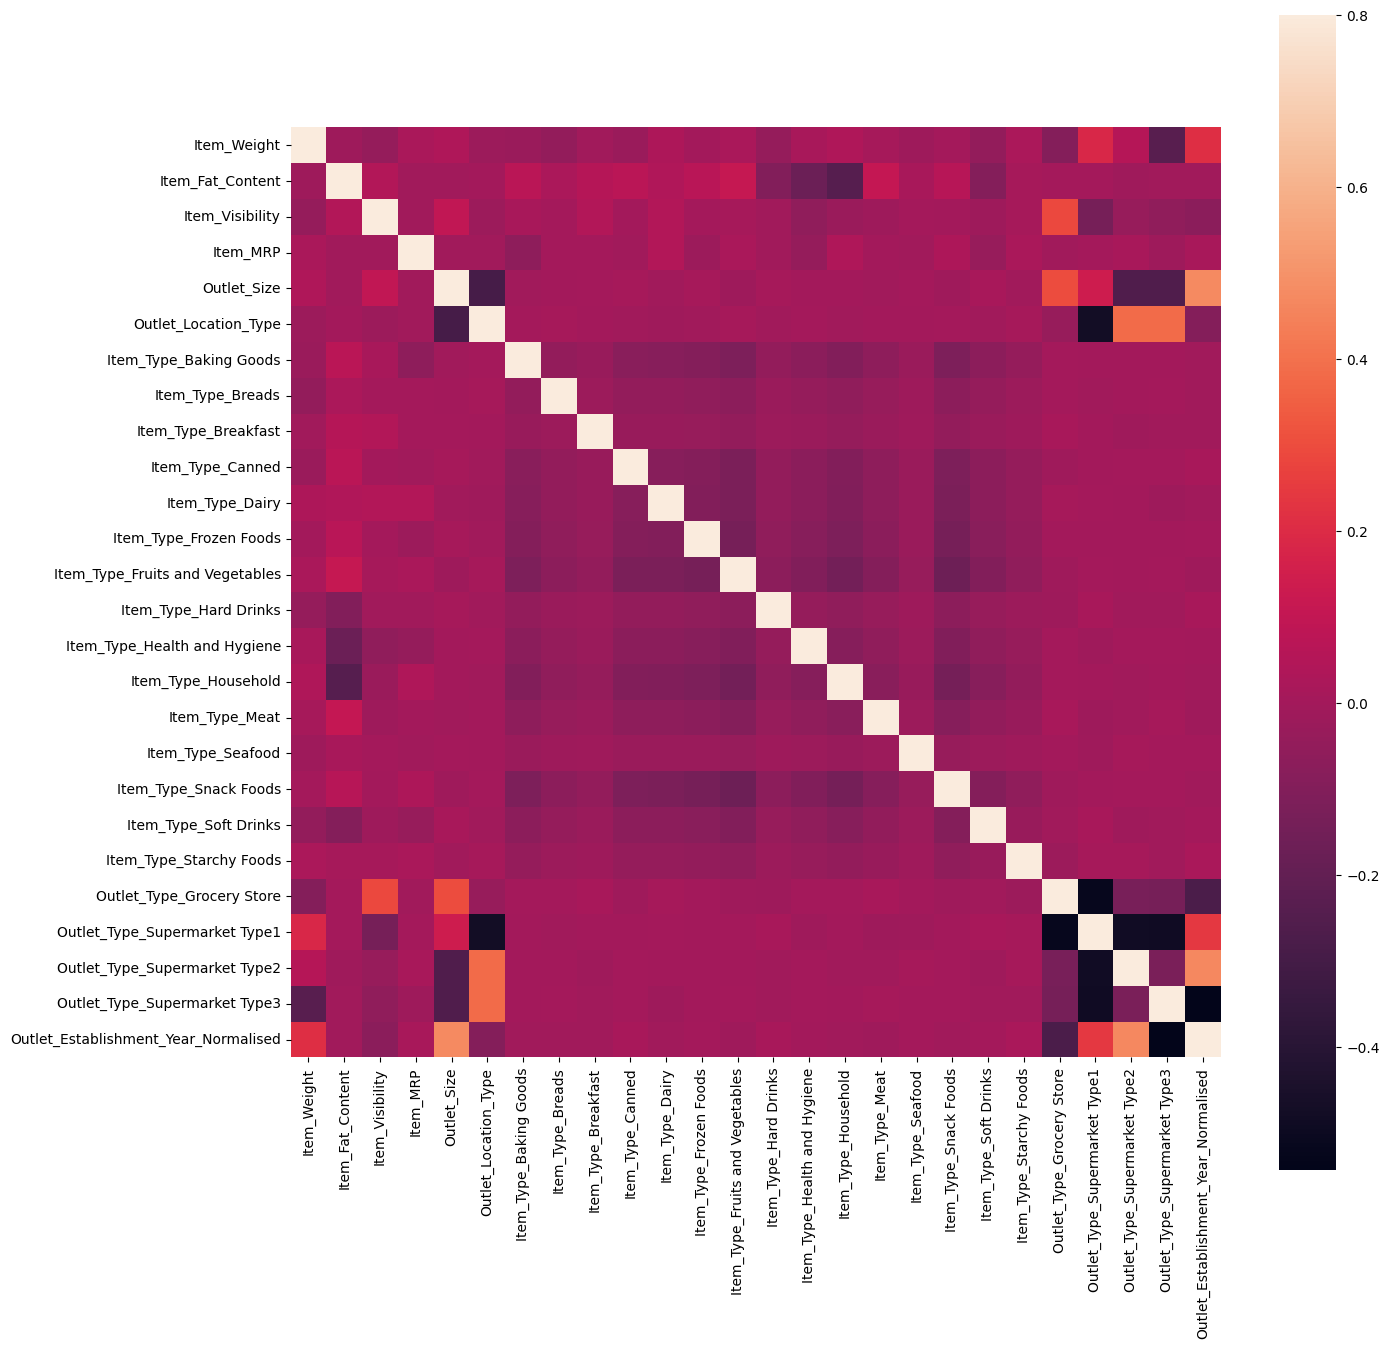

In [42]:
C_mat = X_train.corr()

fig = plt.figure(figsize = (15,15))
sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

**Conclusion**

A good model would have residuals that are normally distributed around 0.

## Model 3. Artificial Neural Network

### Training the neural network

The Sequential model defines an artificial neural network with an input layer of 128 neurons using ReLU activation, followed by three hidden layers with 256 neurons each. The output layer has a single neuron with a linear activation for regression. Compiled with mean absolute error loss and the Adam optimizer, it aims to minimize absolute differences during training. This configuration is suitable for predicting continuous values. The model summary provides insights into its architecture and complexity, facilitating an understanding of its potential predictive capabilities.

In [43]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3456      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 168321 (657.50 KB)
Trainable params: 168321 (657.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Defining a checkpoint

This code defines a Keras callback for model training. The ModelCheckpoint callback is configured to save the model's weights during training based on certain conditions. The variable checkpoint_name specifies the naming pattern for the saved weights files, including the epoch number and the validation loss. The callback is set to monitor the validation loss ('val_loss'), and it will save only the weights of the model that result in the best validation loss (save_best_only=True). The saved weights files will be in HDF5 format ('.hdf5'). This callback is useful for later loading the best weights and preventing overfitting during training by keeping track of the model's performance on the validation set.

In [44]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

### Training the neural network

In [45]:
NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/50
144/171 [========================>.....] - ETA: 0s - loss: 1238.3003 - mean_absolute_error: 1238.3003
Epoch 1: val_loss improved from inf to 1068.73413, saving model to Weights-001--1068.73413.hdf5
171/171 [==============================] - 1s 2ms/step - loss: 1212.5061 - mean_absolute_error: 1212.5061 - val_loss: 1068.7341 - val_mean_absolute_error: 1068.7341
Epoch 2/50
 98/171 [================>.............] - ETA: 0s - loss: 1042.8186 - mean_absolute_error: 1042.8186

/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/171 [===========================>..] - ETA: 0s - loss: 1029.6638 - mean_absolute_error: 1029.6638
Epoch 2: val_loss improved from 1068.73413 to 1025.03638, saving model to Weights-002--1025.03638.hdf5
171/171 [==============================] - 0s 2ms/step - loss: 1031.1060 - mean_absolute_error: 1031.1060 - val_loss: 1025.0364 - val_mean_absolute_error: 1025.0364
Epoch 3/50
152/171 [=========================>....] - ETA: 0s - loss: 1008.7339 - mean_absolute_error: 1008.7339
Epoch 3: val_loss improved from 1025.03638 to 1005.36975, saving model to Weights-003--1005.36975.hdf5
171/171 [==============================] - 0s 2ms/step - loss: 1013.1439 - mean_absolute_error: 1013.1439 - val_loss: 1005.3698 - val_mean_absolute_error: 1005.3698
Epoch 4/50
170/171 [============================>.] - ETA: 0s - loss: 969.3867 - mean_absolute_error: 969.3867
Epoch 4: val_loss improved from 1005.36975 to 928.05316, saving model to Weights-004--928.05316.hdf5
171/171 [============================

### Evaluating

In [46]:
predicted_prices = NN_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, predicted_prices)
print(f"Mean Absolute Error: {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, predicted_prices)
print(f'Mean Squared Error {mse}')

# Calculate RMSE
rmse = mean_squared_error(y_test, predicted_prices, squared=False)
print(f"Root Mean Squared Error: {rmse}")


54/54 [==============================] - 0s 920us/step
Mean Absolute Error: 719.520479773565
Mean Squared Error 1047213.7437739185
Root Mean Squared Error: 1023.3346196498575


/Users/bhavyababuta/.local/share/virtualenvs/big-mart-sales-prediction-PPpMiLjs/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
